# Chi Square Analysis


In [6]:
import pandas as pd
from os import path
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
DATA_FOLDER_PATH = '../data'

In [8]:
new_achs_accidents_data_file_path = path.join(DATA_FOLDER_PATH, 'masked', 'new_achs_accidents_data.csv')
llm_results_file_path = path.join(DATA_FOLDER_PATH, 'outputs', 'llm_classification.csv')
mechanisms_file_path = path.join(DATA_FOLDER_PATH, 'masked','dicc_mecanismo_new_refined2.2.csv')

In [15]:
classified_occupations = pd.read_csv(
    llm_results_file_path,
    names=['index', 'ocupacion', 'clasificacion-oit'],
    on_bad_lines='skip',
    header=0
)

new_achs_accidents_data = pd.read_csv(new_achs_accidents_data_file_path)
merged_occupations = pd.merge(
    new_achs_accidents_data,
    classified_occupations,
    on='ocupacion',
    how='inner'
)

merged_occupations.head()

,id_siniestro,tipo_siniestro,numero_paciente,texto,poblacion,ocupacion,edad,sexo,relato_admision,mecanismo,fecha_creacion,region,index,clasificacion-oit
0,7242107,2,1007001523,LEY \nREPOSO\nTRASLADO A CEM PARA INSTALAR CAN...,QUILICURA,supervisor,29.0,masculino,AL MOMENTO DEL ACCIDENTE ESTABA CAMINO A MI TR...,12.1,2022-01-03,13.0,1,12
1,7243477,2,1006591551,Reposo laboral con alta diferida\nAnalgesia\nM...,TALCA,operario de produccion,25.0,masculino,AL MOMENTO DEL ACCIDENTE ESTABA CAMINO A MI TR...,12.1,2022-01-04,7.0,5,93
2,7244101,1,1005201569,AM: - ALERGIAS: -\n\nPACIENTE REFIERE TROPEZAR...,PROVIDENCIA,coordiandora de laborator,35.0,femenino,AL MOMENTO DEL ACCIDENTE ESTABA CAMINANDO HACI...,12.1,2022-01-04,13.0,6,12
3,7246191,1,1006906539,"\n\n\nCLORURO DE SODIO 0,9% / 100ML BOL COLAP...",CALERA,auxiliar de alimentacion,48.0,femenino,AL MOMENTO DEL ACCIDENTE ESTABA DIRIGIENDOSE A...,12.1,2022-01-05,5.0,9,94
4,7246212,1,1006600768,Ingreso,MAIPU,trabajador social,35.0,masculino,AL MOMENTO DEL ACCIDENTE ESTABA HACIA UNA VISI...,92.2,2022-01-05,13.0,10,26


In [16]:
# Mechanism Analysis

df_dicc = pd.read_csv(mechanisms_file_path, sep=';')
df_dicc= df_dicc.rename(columns={"Codigo SUSESO 2018": "mecanismo"})
df_mecanismos = pd.merge(merged_occupations, df_dicc, on= 'mecanismo')


=== CHI-SQUARE TEST RESULTS ===
Chi-square statistic (χ²): 5916.81
Degrees of freedom: nan
P-value: 0.0001000000
Significance: HIGHLY SIGNIFICANT

This indicates strong statistical evidence of association between accident mechanism and sex.


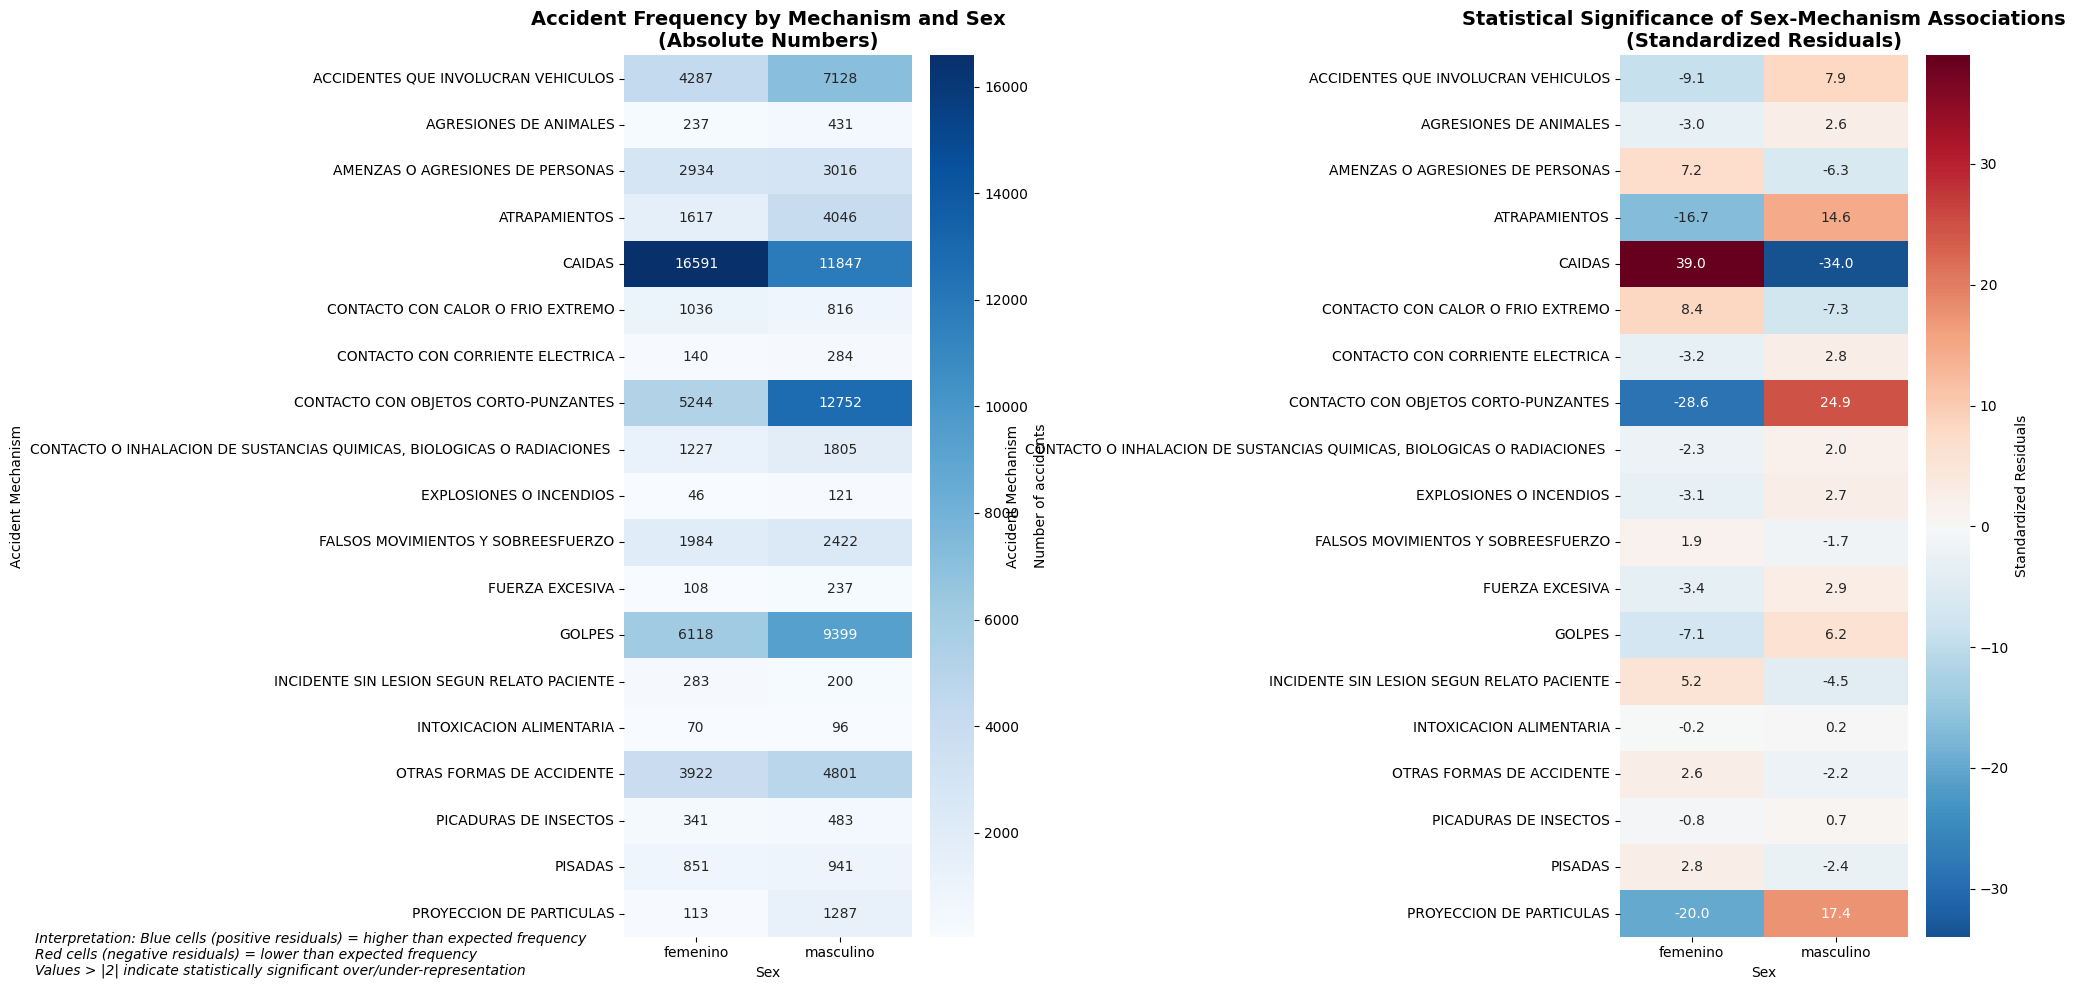


=== MOST SIGNIFICANT PATTERNS ===
(Standardized residuals > |2| indicate statistical significance)

Most over-represented combinations (much higher than expected):
• Femenino workers in CAIDAS: 16591 cases (residual: +39.0)
• Masculino workers in CONTACTO CON OBJETOS CORTO-PUNZANTES: 12752 cases (residual: +24.9)
• Masculino workers in PROYECCION DE PARTICULAS: 1287 cases (residual: +17.4)
• Masculino workers in ATRAPAMIENTOS: 4046 cases (residual: +14.6)
• Femenino workers in CONTACTO CON CALOR O FRIO EXTREMO: 1036 cases (residual: +8.4)

Most under-represented combinations (much lower than expected):
• Masculino workers in CAIDAS: 11847 cases (residual: -34.0)
• Femenino workers in CONTACTO CON OBJETOS CORTO-PUNZANTES: 5244 cases (residual: -28.6)
• Femenino workers in PROYECCION DE PARTICULAS: 113 cases (residual: -20.0)
• Femenino workers in ATRAPAMIENTOS: 1617 cases (residual: -16.7)
• Femenino workers in ACCIDENTES QUE INVOLUCRAN VEHICULOS: 4287 cases (residual: -9.1)


In [18]:
# Chi-square Analysis Visualization
# Statistical analysis of sex differences in accident mechanisms

import numpy as np
from scipy.stats import chi2_contingency, MonteCarloMethod

# Create contingency table with mechanism descriptions
contingency_with_desc = pd.crosstab(df_mecanismos['desc_subforma'], df_mecanismos['sexo'])

# Calculate chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_with_desc.values, correction=False, method=MonteCarloMethod())

print("=== CHI-SQUARE TEST RESULTS ===")
print(f"Chi-square statistic (χ²): {chi2:.2f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p:.10f}")
print(f"Significance: {'HIGHLY SIGNIFICANT' if p < 0.001 else 'SIGNIFICANT' if p < 0.05 else 'NOT SIGNIFICANT'}")
print("\nThis indicates strong statistical evidence of association between accident mechanism and sex.")

# Calculate standardized residuals to identify patterns
residuals = (contingency_with_desc.values - expected) / np.sqrt(expected)
residuals_df = pd.DataFrame(residuals, 
                           index=contingency_with_desc.index, 
                           columns=contingency_with_desc.columns)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# 1. Contingency table heatmap
sns.heatmap(contingency_with_desc, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar_kws={'label': 'Number of accidents'})
ax1.set_title('Accident Frequency by Mechanism and Sex\n(Absolute Numbers)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Sex')
ax1.set_ylabel('Accident Mechanism')
ax1.tick_params(axis='y', rotation=0)

# 2. Standardized residuals heatmap
sns.heatmap(residuals_df, annot=True, fmt='.1f', center=0, cmap='RdBu_r', ax=ax2, 
            cbar_kws={'label': 'Standardized Residuals'})
ax2.set_title('Statistical Significance of Sex-Mechanism Associations\n(Standardized Residuals)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Sex')
ax2.set_ylabel('Accident Mechanism')
ax2.tick_params(axis='y', rotation=0)

# Add interpretation text
fig.text(0.02, 0.02, 
         'Interpretation: Blue cells (positive residuals) = higher than expected frequency\n' +
         'Red cells (negative residuals) = lower than expected frequency\n' +
         'Values > |2| indicate statistically significant over/under-representation',
         fontsize=10, style='italic')

plt.tight_layout()
plt.savefig('chi_square_mechanism_sex_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Show top over/under-represented combinations
print("\n=== MOST SIGNIFICANT PATTERNS ===")
print("(Standardized residuals > |2| indicate statistical significance)")

# Reshape residuals for easier analysis
residuals_flat = []
for mechanism in residuals_df.index:
    for sex in residuals_df.columns:
        residuals_flat.append({
            'mechanism': mechanism,
            'sex': sex,
            'residual': residuals_df.loc[mechanism, sex],
            'count': contingency_with_desc.loc[mechanism, sex]
        })

residuals_analysis = pd.DataFrame(residuals_flat)
significant_patterns = residuals_analysis[abs(residuals_analysis['residual']) > 2].sort_values('residual', key=abs, ascending=False)

print("\nMost over-represented combinations (much higher than expected):")
over_rep = significant_patterns[significant_patterns['residual'] > 2].head(5)
for _, row in over_rep.iterrows():
    print(f"• {row['sex'].title()} workers in {row['mechanism']}: {row['count']} cases (residual: +{row['residual']:.1f})")

print("\nMost under-represented combinations (much lower than expected):")
under_rep = significant_patterns[significant_patterns['residual'] < -2].head(5)
for _, row in under_rep.iterrows():
    print(f"• {row['sex'].title()} workers in {row['mechanism']}: {row['count']} cases (residual: {row['residual']:.1f})")

### Interpretation
Through the Chi-Square test to study the population focusing on the attributes sex and mechanisms we found a strong relationship between the two Sex and Mechanisms. With a p-value of `0.0001` it shows there is relation between sex and mechanism of accident. In particular through residuals also is noted the most over-represented and under-represented combinations between sex.

For Female Sex, the most over-represented mechanism is `FALLS` with a residual of +39.0, followed by `CONTACT WITH EXTREME HEAT OR COLD` with a residual of +8.4
For Male Sex, the most over-represented mechanism is `CONTACT WITH SHARP OBJECTS` with a residual of +24.9, followed by `PARTICLE PROJECTION` with a residual of +17.4

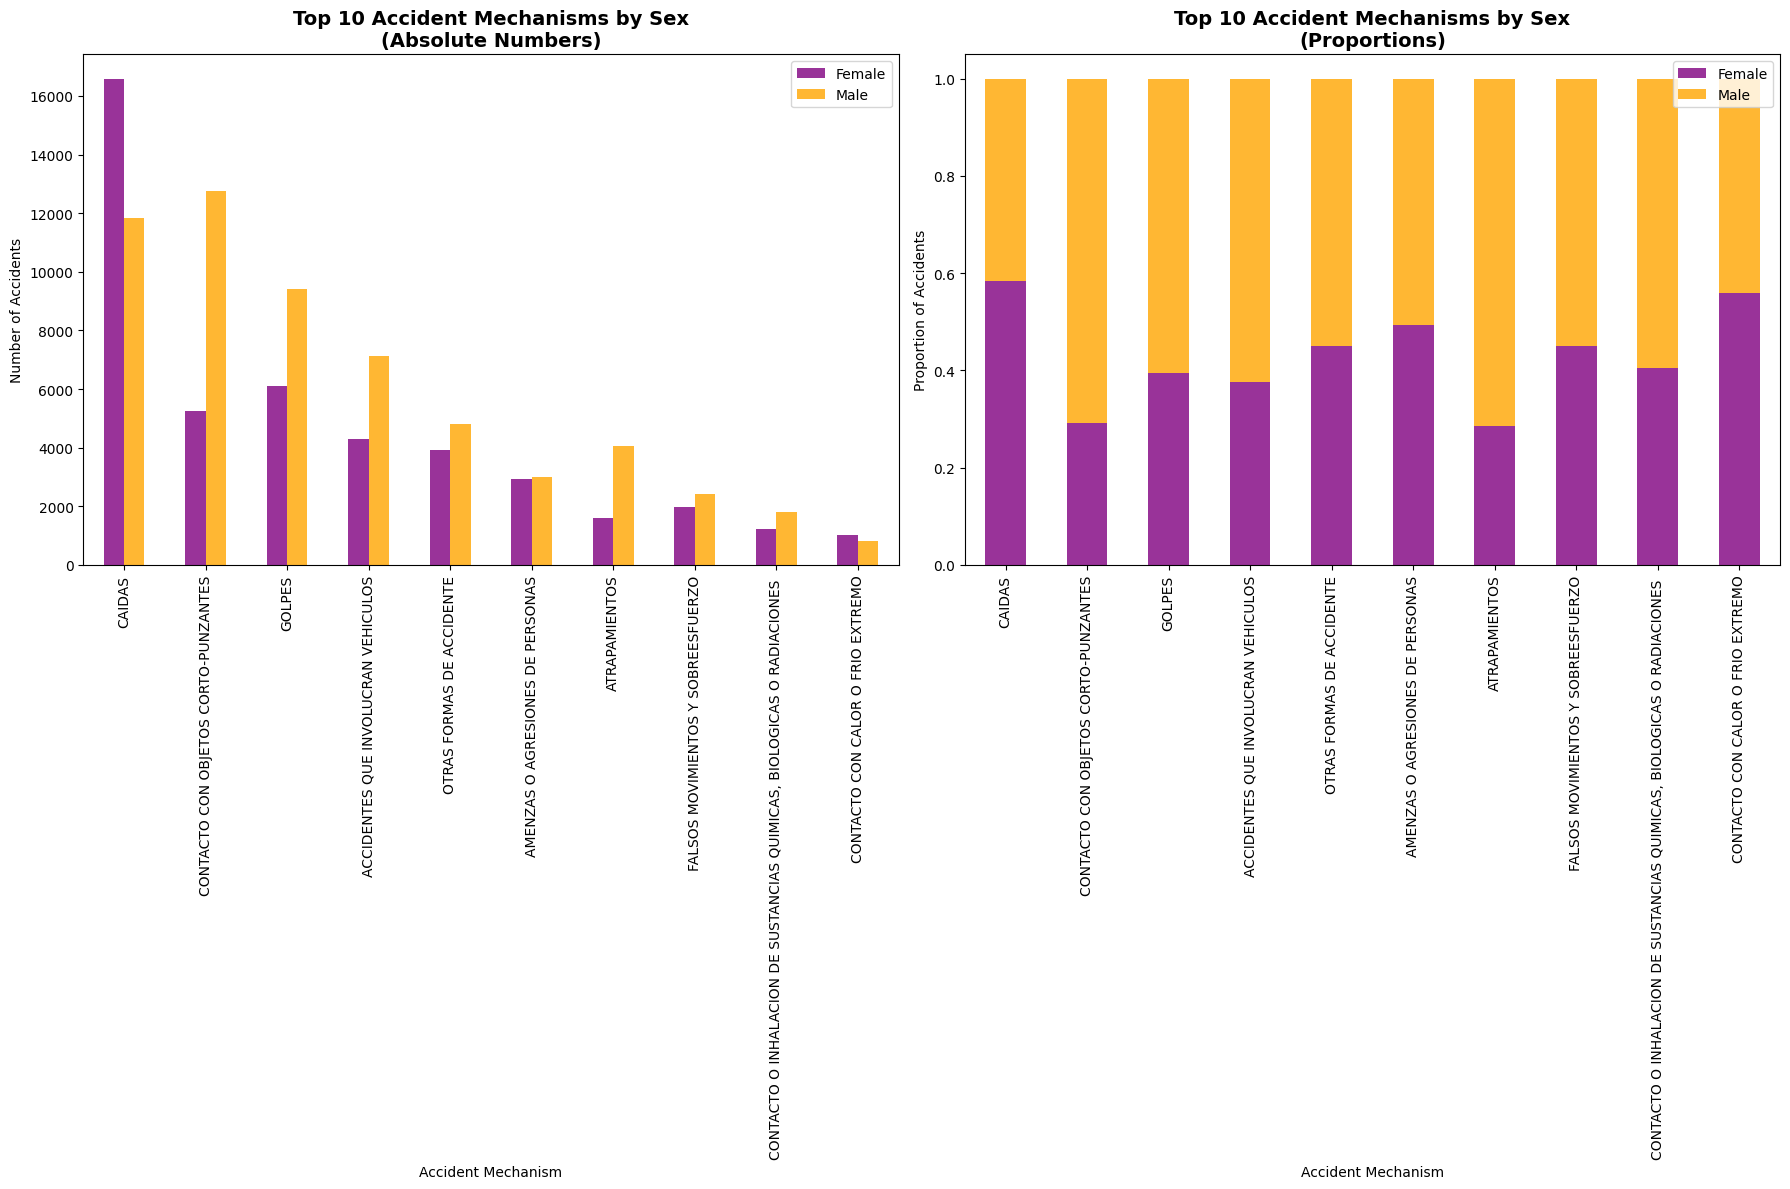

Total accidents analyzed: 109,261
Female accidents: 47,149 (43.2%)
Male accidents: 62,112 (56.8%)

Chi-square test confirms highly significant association (χ² = 5917, p < 0.001)

=== NOTABLE SEX DIFFERENCES (Top 5 mechanisms) ===

CAIDAS:
  • Female: 16,591 cases (58.3%)
  • Male: 11,847 cases (41.7%)
  → MORE COMMON in women (+4,744 cases)

CONTACTO CON OBJETOS CORTO-PUNZANTES:
  • Female: 5,244 cases (29.1%)
  • Male: 12,752 cases (70.9%)
  → MORE COMMON in men (+7,508 cases)

GOLPES:
  • Female: 6,118 cases (39.4%)
  • Male: 9,399 cases (60.6%)
  → MORE COMMON in men (+3,281 cases)

ACCIDENTES QUE INVOLUCRAN VEHICULOS:
  • Female: 4,287 cases (37.6%)
  • Male: 7,128 cases (62.4%)
  → MORE COMMON in men (+2,841 cases)

OTRAS FORMAS DE ACCIDENTE:
  • Female: 3,922 cases (45.0%)
  • Male: 4,801 cases (55.0%)
  → MORE COMMON in men (+879 cases)


In [19]:
# Calculate proportions to better understand the patterns
contingency_prop = contingency_with_desc.div(contingency_with_desc.sum(axis=1), axis=0)

# Get top 10 most common mechanisms
top_mechanisms = contingency_with_desc.sum(axis=1).nlargest(10)

# Create focused visualization

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 12))

# 1. Top 10 mechanisms - absolute numbers
top_data = contingency_with_desc.loc[top_mechanisms.index]
top_data.plot(kind='bar', ax=ax1, color=['purple', 'orange'], alpha=0.8)
ax1.set_title('Top 10 Accident Mechanisms by Sex\n(Absolute Numbers)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Accident Mechanism')
ax1.set_ylabel('Number of Accidents')
ax1.legend(['Female', 'Male'])
ax1.tick_params(axis='x', rotation=90)

# 2. Same data but as proportions
top_prop_data = contingency_prop.loc[top_mechanisms.index]
top_prop_data.plot(kind='bar', ax=ax2, color=['purple', 'orange'], alpha=0.8, stacked=True)
ax2.set_title('Top 10 Accident Mechanisms by Sex\n(Proportions)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Accident Mechanism')
ax2.set_ylabel('Proportion of Accidents')
ax2.legend(['Female', 'Male'])
ax2.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.savefig('top_mechanisms_sex_simple.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Total accidents analyzed: {contingency_with_desc.sum().sum():,}")
print(f"Female accidents: {contingency_with_desc['femenino'].sum():,} ({contingency_with_desc['femenino'].sum()/contingency_with_desc.sum().sum()*100:.1f}%)")
print(f"Male accidents: {contingency_with_desc['masculino'].sum():,} ({contingency_with_desc['masculino'].sum()/contingency_with_desc.sum().sum()*100:.1f}%)")

print(f"\nChi-square test confirms highly significant association (χ² = {chi2:.0f}, p < 0.001)")

print("\n=== NOTABLE SEX DIFFERENCES (Top 5 mechanisms) ===")
for mechanism in top_mechanisms.head(5).index:
    female_count = contingency_with_desc.loc[mechanism, 'femenino']
    male_count = contingency_with_desc.loc[mechanism, 'masculino']
    female_prop = female_count / (female_count + male_count) * 100
    male_prop = male_count / (female_count + male_count) * 100
    
    print(f"\n{mechanism}:")
    print(f"  • Female: {female_count:,} cases ({female_prop:.1f}%)")
    print(f"  • Male: {male_count:,} cases ({male_prop:.1f}%)")
    
    if female_count > male_count:
        print(f"  → MORE COMMON in women (+{female_count - male_count:,} cases)")
    else:
        print(f"  → MORE COMMON in men (+{male_count - female_count:,} cases)")
